## TEAM - 15
## TEAM members:   Shraddha (smedurik) and Uma Maheswara Reddy(usannapu)


In [2]:
pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [13]:
#importing libraries 
import gym
import torch
import random
import pickle 
import gymnasium
import pandas as pd
import numpy as np
from gym import spaces
import torch.nn as nn
from gymnasium import spaces
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

## part 2.1

Step 1
State: [0, 0]
Action: Pickup
Reward: -1
Total Reward: -1
Done: False


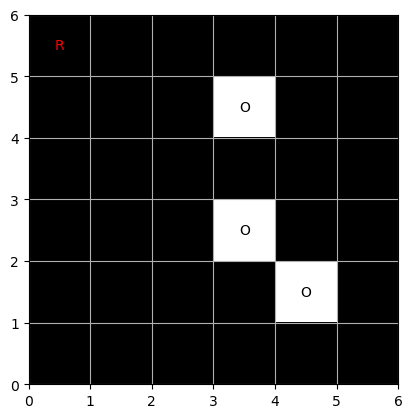

Step 2
State: [0, 0]
Action: Pickup
Reward: -1
Total Reward: -2
Done: False


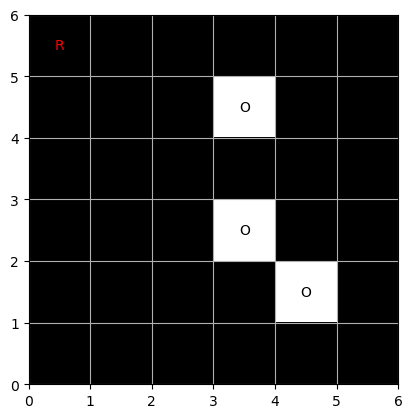

Step 3
State: [0, 0]
Action: Pickup
Reward: -1
Total Reward: -3
Done: False


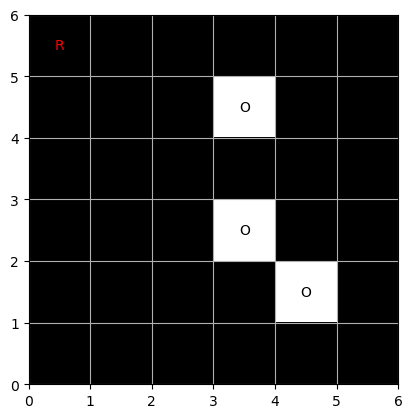

Step 4
State: [0, 0]
Action: Left
Reward: -1
Total Reward: -4
Done: False


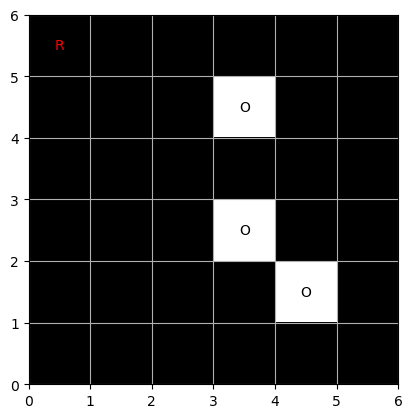

Step 5
State: [0, 1]
Action: Right
Reward: -1
Total Reward: -5
Done: False


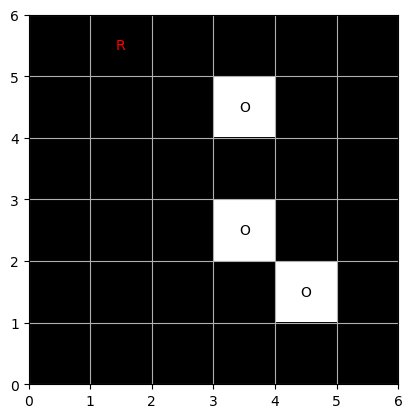

Step 6
State: [1, 1]
Action: Down
Reward: -1
Total Reward: -6
Done: False


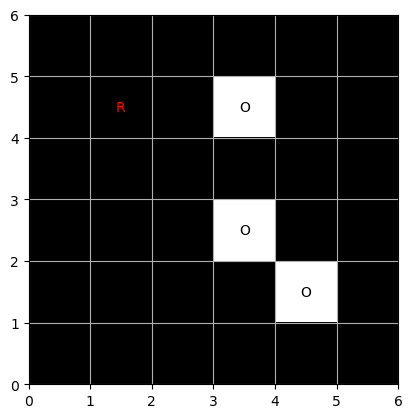

Step 7
State: [2, 1]
Action: Down
Reward: -1
Total Reward: -7
Done: False


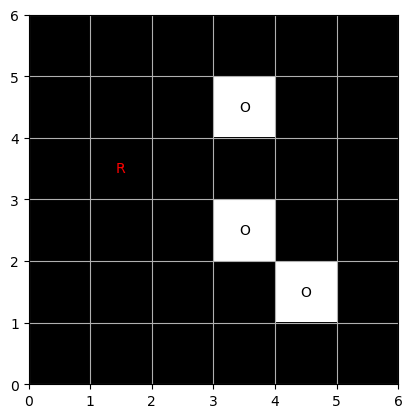

Step 8
State: [2, 0]
Action: Left
Reward: -1
Total Reward: -8
Done: False


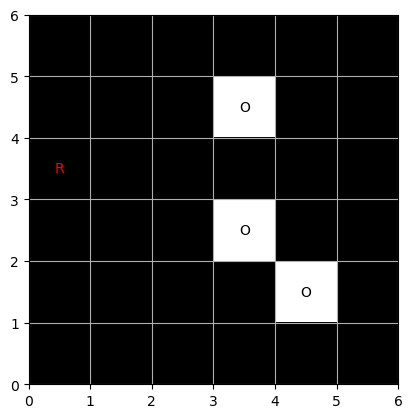

Step 9
State: [2, 0]
Action: Left
Reward: -1
Total Reward: -9
Done: False


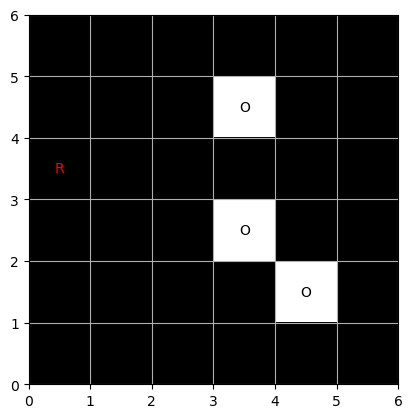

Step 10
State: [2, 1]
Action: Right
Reward: -1
Total Reward: -10
Done: False


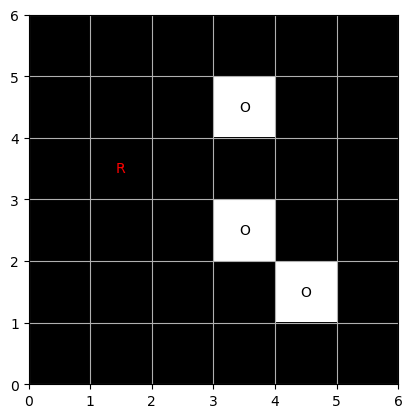

In [19]:
class daenv_deter:
    def __init__(self):
        self.g_size = 6
        self.grid = np.zeros((self.g_size, self.g_size))
        self.rob_pos = [0, 0]
        self.pick_pos = [2, 3]
        self.drop_pos = [5, 5]
        self.obs = [(1, 3), (3, 3), (4, 4)]
        self.carry_item = False
        self.total_steps = 0
        self.total_reward = 0
        self.done = False
        self.action_full = ["Up", "Down", "Left", "Right", "Pickup", "Drop-off"]
        self.reset()
        for obst in self.obs:
            self.grid[obst] = -1
            
    def reset(self):
        self.rob_pos = [0, 0]
        self.carry_item = False
        self.total_steps = 0
        self.total_reward = 0
        self.done = False
        return self.rob_pos, self.carry_item
    
    def step(self, action):
        x, y = self.rob_pos
        reward = -1
        if action == "Up":
            x = max(0, x - 1)
        elif action == "Down":
            x = min(self.g_size - 1, x + 1)
        elif action == "Left":
            y = max(0, y - 1)
        elif action == "Right":
            y = min(self.g_size - 1, y + 1)
        elif action == "Pickup" and self.rob_pos == self.pick_pos:
            self.carry_item = True
        elif action == "Drop-off" and self.rob_pos == self.drop_pos and self.carry_item:
            reward = 20
            self.done = True
        if (x, y) in self.obs:
            reward = -20
            self.done = True
        self.rob_pos = [x, y]
        self.total_steps += 1
        self.total_reward += reward

        return self.rob_pos, reward, self.done, {}

    def random_action(self):
        return random.choice(self.action_full)
    
    def render(self):
        grid = np.zeros((self.g_size, self.g_size), dtype=str)
        grid.fill(".")
        grid[self.rob_pos[0], self.rob_pos[1]] = "R"
        grid[self.pick_pos[0], self.pick_pos[1]] = "P"
        grid[self.drop_pos[0], self.drop_pos[1]] = "D"
        for obst in self.obs:
            grid[obst] = "O"
        plt.imshow(grid == "O", cmap="gray", extent=(0, self.g_size, 0, self.g_size))
        for i in range(self.g_size):
            for j in range(self.g_size):
                text = grid[i, j]
                plt.text(j + 0.5, self.g_size - i - 0.5, text, ha="center", va="center",
                         color="red" if text == "R" else "black")
        plt.xticks(np.arange(0, self.g_size + 1, 1))
        plt.yticks(np.arange(0, self.g_size + 1, 1))
        plt.grid(True)
        plt.show()


environ = daenv_deter()
state, carrying = environ.reset()

for step in range(10):
    action = environ.random_action()
    next_state, reward, done, _ = environ.step(action)

    print(f"Step {step + 1}")
    print(f"State: {next_state}")
    print(f"Action: {action}")
    print(f"Reward: {reward}")
    print(f"Total Reward: {environ.total_reward}")
    print(f"Done: {done}")
    environ.render()

    if done:
        break

In [69]:
#defining the dqnetwork class 
class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        #defineing nn 
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),  #layer 1
            nn.ReLU(),                  #activation
            nn.Linear(128, 256),        #layer 2
            nn.ReLU(),                  #activation
            nn.Linear(256, output_dim)  #output layer
        )

    def forward(self, state):
        #performing forward pass 
        return self.fc(state)
        
#defining exprience replay 
class ExperienceReplay:
    def __init__(self, buffer_capacity):
        self.buffer = deque(maxlen=buffer_capacity) #initilize buffer with max capacity 
    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))#store expirience in buffer 
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) #sample of batch experience 
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
    def __len__(self):
        return len(self.buffer) #return the current size of buffer 

def flatten_state(rob_pos, carry_item):
    return np.array([rob_pos[0], rob_pos[1], int(carry_item)])
    
#hyperparameters
STATE_DIM = 3  
ACTION_DIM = 6  
BUFFER_SIZE = 10000
BATCH_SIZE = 32
DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.001
TARGET_UPDATE_FREQUENCY = 10
TOTAL_EPISODES = 1000
EPSILON_START = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MAX_STEPS = 500

def train_dqn(env, online_q_network, target_q_network, replay_buffer, optimizer, total_episodes, batch_size, gamma, epsilon_start, epsilon_decay, epsilon_min, target_update_freq, max_steps):
    epsilon = epsilon_start #initialize epsilon 
    episode_rewards = [] #list to store total rewards per episode 
    epsilon_history = [] #list to store total epsilon values 
    for episode in range(total_episodes):
        state, carry_item = env.reset() #reset the environment 
        state = flatten_state(state, carry_item)  #flatten the initial state 
        episode_reward = 0
        for step in range(max_steps):
            if np.random.rand() < epsilon:  #epsilon greedy 
                action = random.choice(range(ACTION_DIM)) #choosing a random action 
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0) #convert state to tensor 
                with torch.no_grad():
                    q_values = online_q_network(state_tensor) #get q values 
                    action = torch.argmax(q_values).item()
            #take action 
            next_state, reward, done, info = env.step(env.action_full[action])
            next_state = flatten_state(next_state, env.carry_item)  
            episode_reward += reward
            replay_buffer.store(state, action, reward, next_state, done)
            state = next_state
            #train the network 
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states_tensor = torch.FloatTensor(states)
                actions_tensor = torch.LongTensor(actions).unsqueeze(1)
                rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1)
                next_states_tensor = torch.FloatTensor(next_states)
                dones_tensor = torch.FloatTensor(dones).unsqueeze(1)
                #get current q values 
                current_q_values = online_q_network(states_tensor).gather(1, actions_tensor)
                #cal target q values 
                with torch.no_grad():
                    max_next_q_values = target_q_network(next_states_tensor).max(1)[0].unsqueeze(1)
                    target_q_values = rewards_tensor + gamma * max_next_q_values * (1 - dones_tensor)
                #compute loss 
                loss = nn.MSELoss()(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if done:
                break
        #update epsilon 
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        episode_rewards.append(episode_reward)
        epsilon_history.append(epsilon)
        if episode % target_update_freq == 0:
            target_q_network.load_state_dict(online_q_network.state_dict())
        print(f"Episode: {episode + 1}, Reward: {episode_reward}, Epsilon: {epsilon}")
    return episode_rewards, epsilon_history


Episode: 1, Reward: -69, Epsilon: 0.995
Episode: 2, Reward: -34, Epsilon: 0.990025
Episode: 3, Reward: -32, Epsilon: 0.985074875
Episode: 4, Reward: -41, Epsilon: 0.9801495006250001
Episode: 5, Reward: -33, Epsilon: 0.9752487531218751
Episode: 6, Reward: -107, Epsilon: 0.9703725093562657
Episode: 7, Reward: -33, Epsilon: 0.9655206468094844
Episode: 8, Reward: -156, Epsilon: 0.960693043575437
Episode: 9, Reward: -76, Epsilon: 0.9558895783575597
Episode: 10, Reward: -52, Epsilon: 0.9511101304657719
Episode: 11, Reward: -39, Epsilon: 0.946354579813443
Episode: 12, Reward: -114, Epsilon: 0.9416228069143757
Episode: 13, Reward: -39, Epsilon: 0.9369146928798039
Episode: 14, Reward: -64, Epsilon: 0.9322301194154049
Episode: 15, Reward: -47, Epsilon: 0.9275689688183278
Episode: 16, Reward: -45, Epsilon: 0.9229311239742362
Episode: 17, Reward: -104, Epsilon: 0.918316468354365
Episode: 18, Reward: -140, Epsilon: 0.9137248860125932
Episode: 19, Reward: -29, Epsilon: 0.9091562615825302
Episode: 20

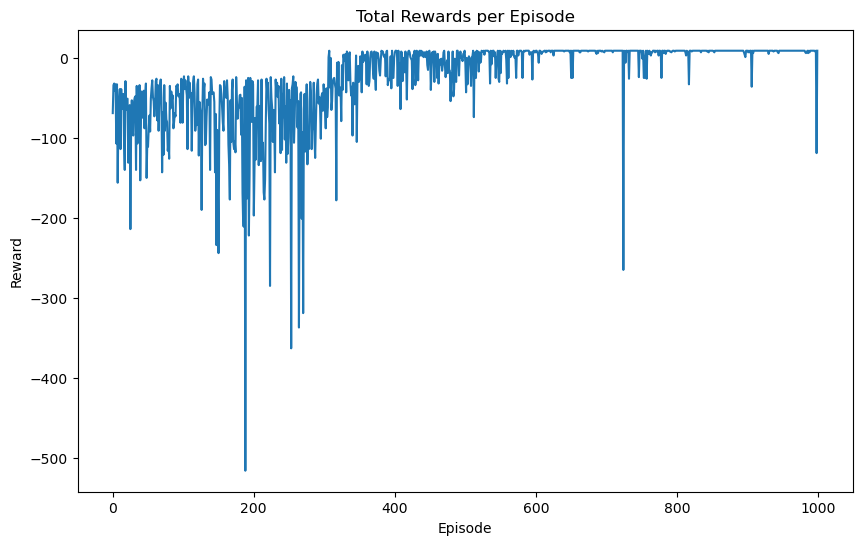

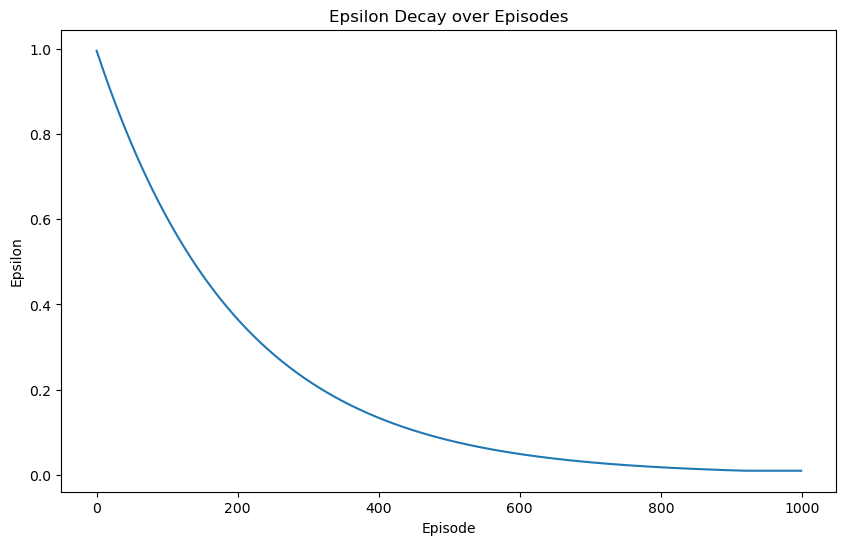

In [71]:
#plot total reward 
def plot_metrics(rewards, epsilon_values):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Total Rewards per Episode')
    plt.show()
    #epsilon decay plot
    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_values)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay over Episodes')
    plt.show()
    
if __name__ == "__main__":
    env = daenv_deter()  
    online_q_network = DQNetwork(STATE_DIM, ACTION_DIM)
    target_q_network = DQNetwork(STATE_DIM, ACTION_DIM)
    target_q_network.load_state_dict(online_q_network.state_dict())
    replay_buffer = ExperienceReplay(BUFFER_SIZE)
    optimizer = optim.Adam(online_q_network.parameters(), lr=LEARNING_RATE)
    rewards, epsilon_values = train_dqn(env,online_q_network,target_q_network,replay_buffer,optimizer,TOTAL_EPISODES,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,EPSILON_DECAY,EPSILON_MIN,TARGET_UPDATE_FREQUENCY,MAX_STEPS)
    dqn_rewards = rewards 
    plot_metrics(rewards, epsilon_values)
    with open('smedurik_usannapu_assignment2_part2_dqn_warehouserobot.pkl', 'wb') as f:
        pickle.dump(online_q_network.state_dict(), f)

In [73]:
#function to flatten state 
def flatten_state(rob_pos, carry_item):
    return np.array([rob_pos[0], rob_pos[1], int(carry_item)])
#initialize model for evluation 
model_for_eval = DQNetwork(STATE_DIM, ACTION_DIM)

#load train model from pkl file 
with open('smedurik_usannapu_assignment2_part2_dqn_warehouserobot.pkl', 'rb') as f:
    model_weights = pickle.load(f)
model_for_eval.load_state_dict(model_weights)
model_for_eval.eval()
#set no of evaluation episodes
eval_episodes = 5
eval_rewards = []
max_steps_per_episode = 5
env = daenv_deter()
for episode in range(eval_episodes):
    state, carry_item = env.reset()
    state = flatten_state(state, carry_item)
    episode_reward = 0

    for step in range(max_steps_per_episode):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = model_for_eval(state_tensor)
            action = torch.argmax(q_values).item()
        next_state, reward, done, _ = env.step(env.action_full[action])
        next_state = flatten_state(next_state, env.carry_item)
        state = next_state
        episode_reward += reward
        if done:
            break

    eval_rewards.append(episode_reward)

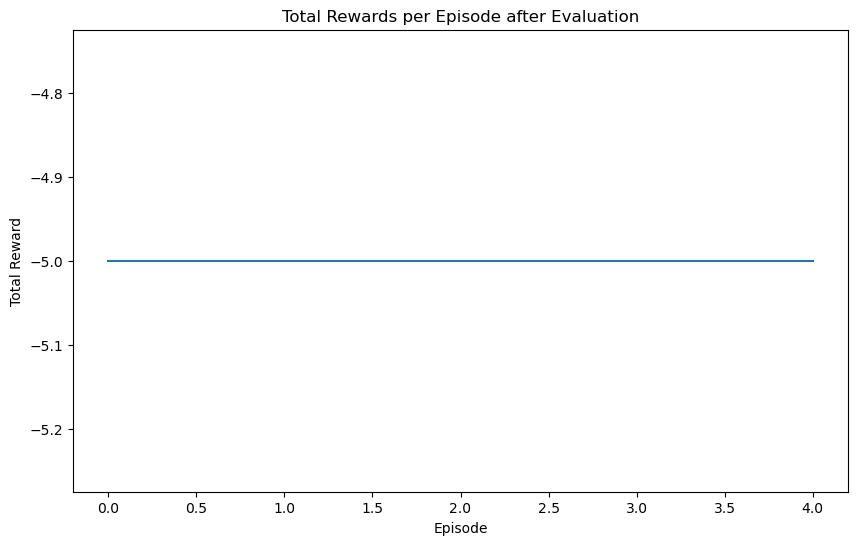

Average Reward over 5 episodes: -5.00


In [75]:
#total rewards graph
plt.figure(figsize=(10, 6))
plt.plot(eval_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards per Episode after Evaluation')
plt.show()

avg_reward = np.mean(eval_rewards)
print(f"Average Reward over {eval_episodes} episodes: {avg_reward:.2f}")

## part 2.2

### Clif-Walking

In [30]:
#defining dqnetwork
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128), #layer 1
            nn.ReLU(),                 #activation 
            nn.Linear(128, 256),       #layer 2
            nn.ReLU(),                 #activation
            nn.Linear(256, output_dim) #output 
        )

    def forward(self, x):
        #performing forward pass 
        return self.fc(x)
        
#defining exprience replay 
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity) #initilize buffer with max capacity 

    def push(self, state, action, reward, next_state, done):
        #store tranisition in buffer 
        self.buffer.append((
            np.array(state, dtype=np.float32),
            action,
            reward,
            np.array(next_state, dtype=np.float32),
            done
        ))
    def sample(self, batch_size):
        #random batch of transitions 
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer) #return the current size of buffer 
        
#hyperparameters 
input_dim = 48 
output_dim = 4 
replay_buffer_size = 50000
batch_size = 64
gamma = 0.95
learning_rate = 0.001
target_update_frequency = 10
num_episodes = 1000
initial_epsilon_rate = 1.0
epsilon_decay = 0.995
min_epsilon_rate = 0.01
#function to convert to one hot encoding 

def one_hot_state(state, num_states=48):
    one_hot = np.zeros(num_states, dtype=np.float32) #zero vector 
    one_hot[state] = 1.0
    return one_hot
#training function for dqn agent 
def train_dqn(env, num_episodes, model, target_model, replay_buffer, optimizer, initial_epsilon_rate):
    rewards_list = []
    epsilon_rates = []
    epsilon_rate = initial_epsilon_rate
    for episode in range(num_episodes):
        state, info = env.reset()  
        state = one_hot_state(state) 
        episode_reward = 0
        for step in range(1000):
            #explore with probability epsilon if not exploit
            if np.random.rand() < epsilon_rate:
                action = env.action_space.sample() #exploration
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0) #prepare state for model 
                with torch.no_grad():
                    q_values = model(state_tensor)
                    action = torch.argmax(q_values).item()

            #take action in environment 
            next_state, reward, done, info , e_info = env.step(action)
            next_state = one_hot_state(next_state)
            episode_reward += reward
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            #perform traning if there are enough samples 
            if len(replay_buffer) >= batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size)
                batch_states_tensor = torch.FloatTensor(batch_states)
                batch_actions_tensor = torch.LongTensor(batch_actions).unsqueeze(1)
                batch_rewards_tensor = torch.FloatTensor(batch_rewards).unsqueeze(1)
                batch_next_states_tensor = torch.FloatTensor(batch_next_states)
                batch_dones_tensor = torch.FloatTensor(batch_dones).unsqueeze(1)
                #compute current q values 
                q_values = model(batch_states_tensor).gather(1, batch_actions_tensor)
                with torch.no_grad():
                    next_q_values = target_model(batch_next_states_tensor).max(1)[0].unsqueeze(1)
                    target_q_values = batch_rewards_tensor + gamma * next_q_values * (1 - batch_dones_tensor)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if done:
                break
        #update target network
        if episode % target_update_frequency == 0:
            target_model.load_state_dict(model.state_dict())

        #decay epsilon rate
        epsilon_rate = max(epsilon_rate * epsilon_decay, min_epsilon_rate)
        rewards_list.append(episode_reward)
        epsilon_rates.append(epsilon_rate)
        print(f"Episode: {episode + 1}, Reward: {episode_reward}, Epsilon Rate: {epsilon_rate}")
    return rewards_list, epsilon_rates

Episode: 1, Reward: -9217, Epsilon Rate: 0.995
Episode: 2, Reward: -10504, Epsilon Rate: 0.990025
Episode: 3, Reward: -8722, Epsilon Rate: 0.985074875
Episode: 4, Reward: -11296, Epsilon Rate: 0.9801495006250001
Episode: 5, Reward: -9910, Epsilon Rate: 0.9752487531218751
Episode: 6, Reward: -9316, Epsilon Rate: 0.9703725093562657
Episode: 7, Reward: -9910, Epsilon Rate: 0.9655206468094844
Episode: 8, Reward: -11494, Epsilon Rate: 0.960693043575437
Episode: 9, Reward: -10405, Epsilon Rate: 0.9558895783575597
Episode: 10, Reward: -10999, Epsilon Rate: 0.9511101304657719
Episode: 11, Reward: -8128, Epsilon Rate: 0.946354579813443
Episode: 12, Reward: -10900, Epsilon Rate: 0.9416228069143757
Episode: 13, Reward: -10900, Epsilon Rate: 0.9369146928798039
Episode: 14, Reward: -10009, Epsilon Rate: 0.9322301194154049
Episode: 15, Reward: -9217, Epsilon Rate: 0.9275689688183278
Episode: 16, Reward: -8623, Epsilon Rate: 0.9229311239742362
Episode: 17, Reward: -12286, Epsilon Rate: 0.918316468354

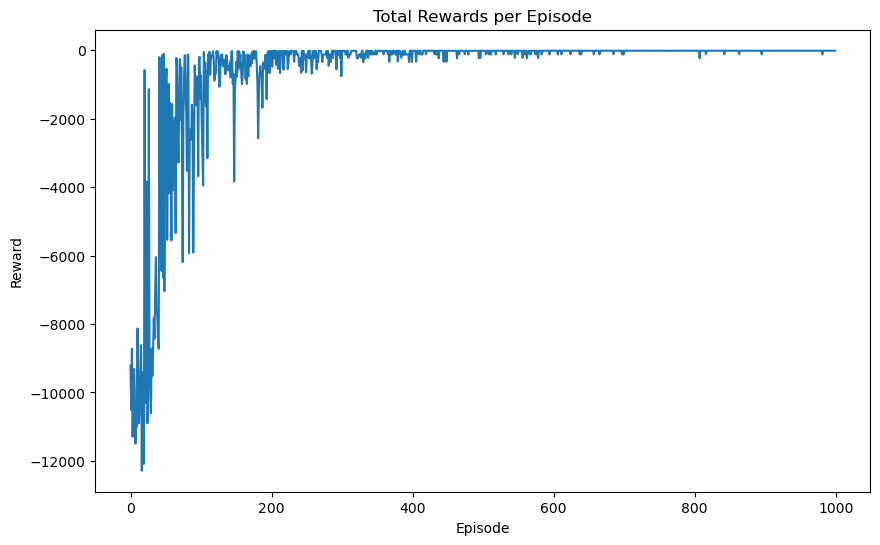

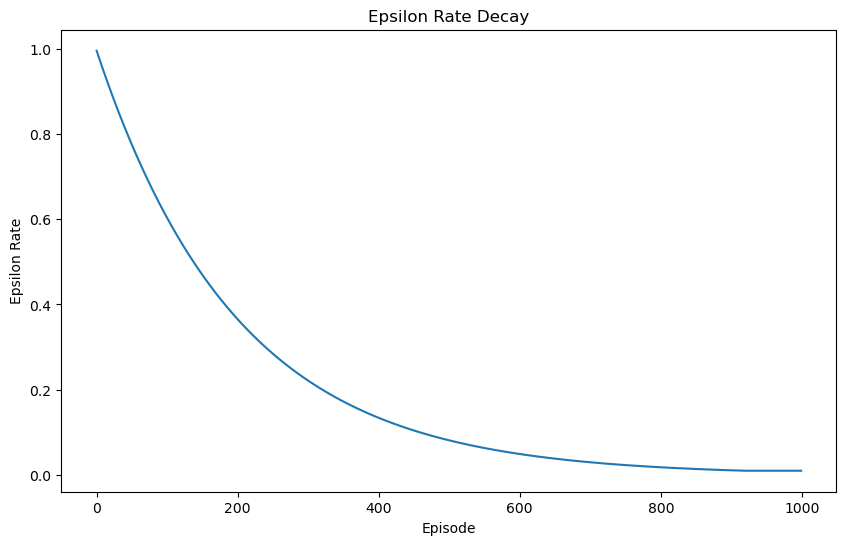

In [32]:
#plot total reward per episode 
def plot_results(rewards_list, epsilon_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards_list)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Total Rewards per Episode')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_rates)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Rate')
    plt.title('Epsilon Rate Decay')
    plt.show()

if __name__ == "__main__":
    env = gym.make('CliffWalking-v0')

    model = DQN(input_dim, output_dim)
    target_model = DQN(input_dim, output_dim)
    target_model.load_state_dict(model.state_dict())
    replay_buffer = ReplayBuffer(replay_buffer_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    rewards_list, epsilon_rates = train_dqn(env, num_episodes, model, target_model, replay_buffer, optimizer, initial_epsilon_rate)
    plot_results(rewards_list, epsilon_rates)
    dqn_rewards_cliffwalking = rewards_list
    with open("smedurik_usannapu_assignment2_part2_dqn_cliffwalking.pkl", "wb") as f:
        pickle.dump(model.state_dict(), f)


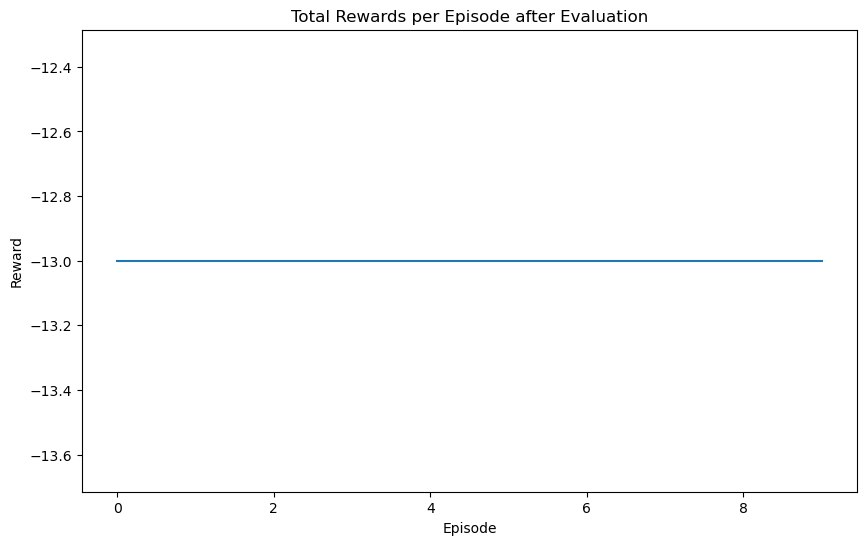


Average Reward over 10 Evaluation Episodes: -13.00


In [14]:
model_for_eval = DQN(input_dim, output_dim)
#load trained dqn model 
with open('smedurik_usannapu_assignment2_part2_dqn_cliffwalking.pkl', 'rb') as f:
    model_weights = pickle.load(f)
    model_for_eval.load_state_dict(model_weights)
    model_for_eval.eval()
#set no of evaluation episodes 
num_eval_episodes = 10
eval_rewards = []
#loop through the number of evaluation episodes 
for episode in range(num_eval_episodes):
    state, _ = env.reset()
    state = one_hot_state(state)  
    episode_reward = 0
    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = model_for_eval(state_tensor)
            action = torch.argmax(q_values).item()
        next_state, reward, done, info, e_info = env.step(action)
        episode_reward += reward
        next_state = one_hot_state(next_state)  
        state = next_state

        if done:
            break
    eval_rewards.append(episode_reward)
#plot the total rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(eval_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Total Rewards per Episode after Evaluation')
plt.show()
avg_reward = np.mean(eval_rewards)
print(f"\nAverage Reward over {num_eval_episodes} Evaluation Episodes: {avg_reward:.2f}")


## PART 2.2 
CARTPOLE - V1

In [77]:
class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),  #layer 1
            nn.ReLU(),                  #activation
            nn.Linear(128, 256),        #layer 2
            nn.ReLU(),                  #activation
            nn.Linear(256, output_dim)  #output 
        )

    def forward(self, state):
        #performing forward pass
        return self.fc(state)
#experience replay buffer
class ExperienceReplay:
    def __init__(self, buffer_capacity):
        self.buffer = deque(maxlen=buffer_capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)
#hyperparameters 
STATE_DIM = 4
ACTION_DIM = 2
BUFFER_SIZE = 20000
BATCH_SIZE = 64  
DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.002 
TARGET_UPDATE_FREQUENCY = 10
TOTAL_EPISODES = 2000
EPSILON_START = 1.0
EPSILON_DECAY = 0.997  
EPSILON_MIN = 0.01
MAX_STEPS = 500
#function to train the DQN
def train_dqn(env, online_q_network, target_q_network, replay_buffer, optimizer, total_episodes, batch_size, gamma, epsilon_start, epsilon_decay, epsilon_min, target_update_freq, max_steps):
    epsilon = epsilon_start
    episode_rewards = []
    epsilon_history = []
    early_stop_threshold = 470
    reward_window = 100  

    #loop through each episode
    for episode in range(total_episodes):
        state, info = env.reset()
        episode_reward = 0
        for step in range(max_steps):
            #epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = online_q_network(state_tensor)
                    action = torch.argmax(q_values).item()
            #take a step in the environment
            next_state, reward, done, info, _ = env.step(action)
            episode_reward += reward
            replay_buffer.store(state, action, reward, next_state, done)
            state = next_state
            #train the network
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states_tensor = torch.FloatTensor(states)
                actions_tensor = torch.LongTensor(actions).unsqueeze(1)
                rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1)
                next_states_tensor = torch.FloatTensor(next_states)
                dones_tensor = torch.FloatTensor(dones).unsqueeze(1)
                #get current Q-values
                current_q_values = online_q_network(states_tensor).gather(1, actions_tensor)
                #calculate target Q-values
                with torch.no_grad():
                    max_next_q_values = target_q_network(next_states_tensor).max(1)[0].unsqueeze(1)
                    target_q_values = rewards_tensor + gamma * max_next_q_values * (1 - dones_tensor)
                loss = nn.MSELoss()(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if done:
                break
        #update exploration rate
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        episode_rewards.append(episode_reward)
        epsilon_history.append(epsilon)
        #update the target network
        if episode % target_update_freq == 0:
            target_q_network.load_state_dict(online_q_network.state_dict())
        
        #early stopping if average reward over last 100 episodes exceeds threshold
        if episode >= reward_window:
            avg_reward = np.mean(episode_rewards[-reward_window:])
            if avg_reward >= early_stop_threshold:
                print(f"Early stopping at episode {episode + 1} with average reward {avg_reward}")
                break

        print(f"Episode: {episode + 1}, Reward: {episode_reward}, Epsilon: {epsilon}")
    return episode_rewards, epsilon_history


Episode: 1, Reward: 13.0, Epsilon: 0.997
Episode: 2, Reward: 15.0, Epsilon: 0.994009
Episode: 3, Reward: 32.0, Epsilon: 0.991026973
Episode: 4, Reward: 33.0, Epsilon: 0.988053892081
Episode: 5, Reward: 14.0, Epsilon: 0.985089730404757
Episode: 6, Reward: 25.0, Epsilon: 0.9821344612135428
Episode: 7, Reward: 10.0, Epsilon: 0.9791880578299021
Episode: 8, Reward: 21.0, Epsilon: 0.9762504936564125
Episode: 9, Reward: 32.0, Epsilon: 0.9733217421754432
Episode: 10, Reward: 11.0, Epsilon: 0.9704017769489168
Episode: 11, Reward: 44.0, Epsilon: 0.9674905716180701
Episode: 12, Reward: 44.0, Epsilon: 0.9645880999032158
Episode: 13, Reward: 24.0, Epsilon: 0.9616943356035061
Episode: 14, Reward: 9.0, Epsilon: 0.9588092525966956
Episode: 15, Reward: 19.0, Epsilon: 0.9559328248389055
Episode: 16, Reward: 10.0, Epsilon: 0.9530650263643888
Episode: 17, Reward: 15.0, Epsilon: 0.9502058312852957
Episode: 18, Reward: 16.0, Epsilon: 0.9473552137914398
Episode: 19, Reward: 52.0, Epsilon: 0.9445131481500655


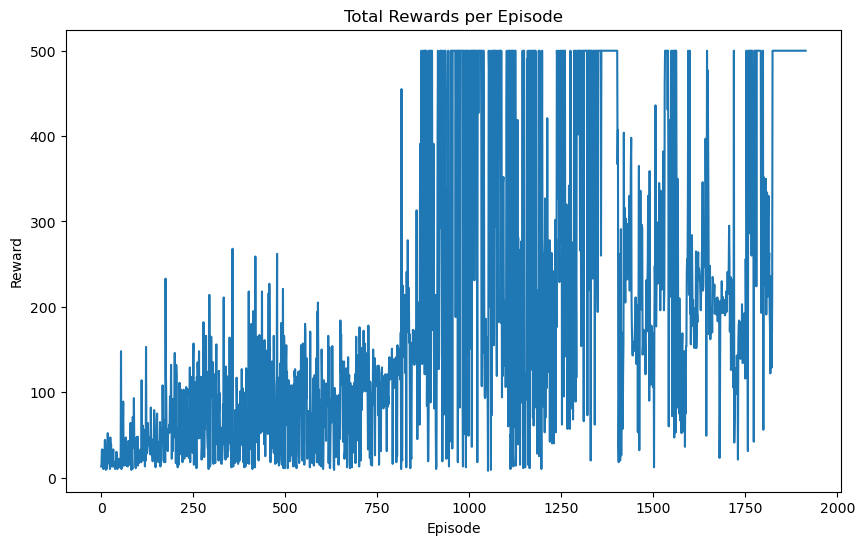

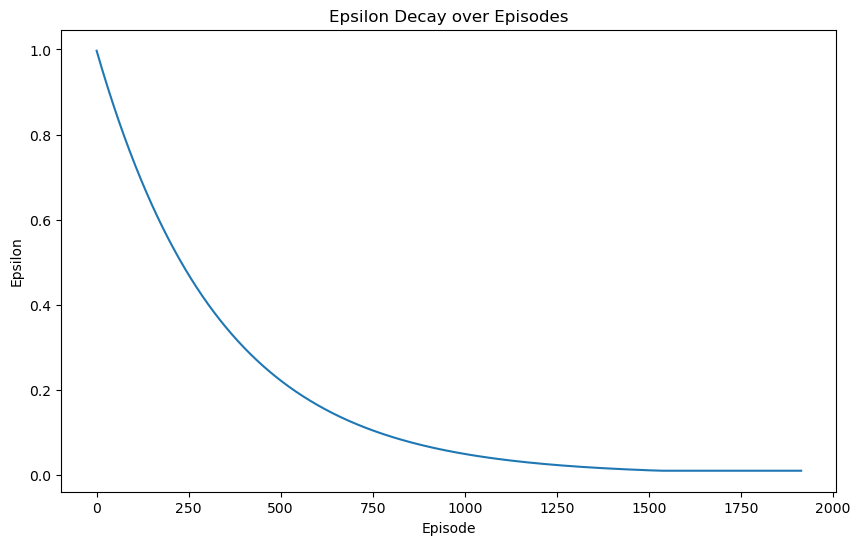

In [52]:
#plot total reward per episode 
def plot_metrics(rewards, epsilon_values):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Total Rewards per Episode')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_values)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay over Episodes')
    plt.show()
#main execution 
if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    online_q_network = DQNetwork(STATE_DIM, ACTION_DIM)
    target_q_network = DQNetwork(STATE_DIM, ACTION_DIM)
    target_q_network.load_state_dict(online_q_network.state_dict())
    replay_buffer = ExperienceReplay(BUFFER_SIZE)
    optimizer = optim.Adam(online_q_network.parameters(), lr=LEARNING_RATE)
    rewards, epsilon_values = train_dqn(env,online_q_network,target_q_network,replay_buffer,optimizer,TOTAL_EPISODES,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,EPSILON_DECAY,EPSILON_MIN,TARGET_UPDATE_FREQUENCY,MAX_STEPS)
    dqn_rewards_cartpole = rewards
    plot_metrics(rewards, epsilon_values)
    with open('cartpole_dqn.pkl', 'wb') as f:
        pickle.dump(online_q_network.state_dict(), f)


In [61]:
num_eval_episodes = 100
model_for_eval = DQNetwork(STATE_DIM, ACTION_DIM)
#load the trained model weights
with open('cartpole_dqn.pkl', 'rb') as f:
    model_weights = pickle.load(f)
    model_for_eval.load_state_dict(model_weights)
    model_for_eval.eval()
    num_eval_runs = 5
all_eval_rewards = []

for run in range(num_eval_runs):
    eval_rewards = []
    for episode in range(num_eval_episodes):
        state, info = env.reset()
        episode_reward = 0
        for step in range(MAX_STEPS):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = model_for_eval(state_tensor)
                action = torch.argmax(q_values).item()  # Greedy action 
            next_state, reward, done, info, e_info = env.step(action)
            episode_reward += reward
            state = next_state
            if done:
                break  
        eval_rewards.append(episode_reward)
    all_eval_rewards.append(eval_rewards)
# Average the rewards from all runs
avg_rewards_per_episode = np.mean(all_eval_rewards, axis=0)

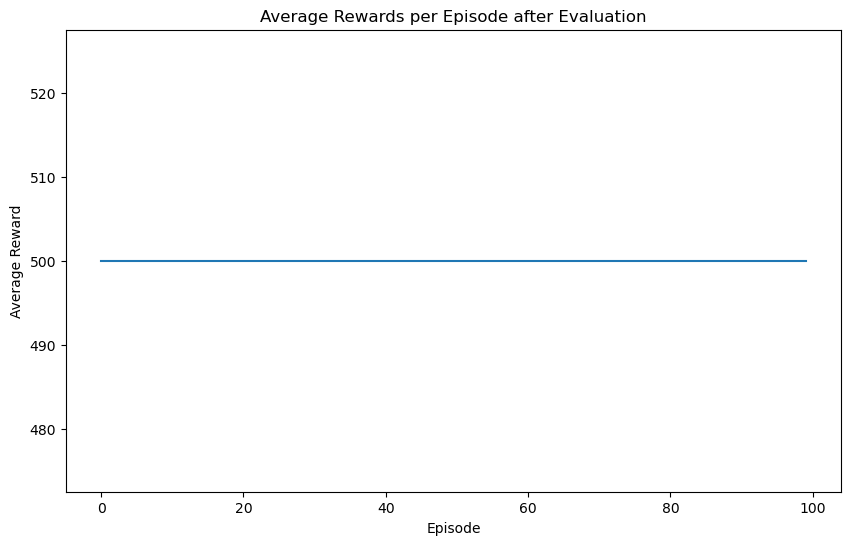


Overall Average Reward over 100 Evaluation Episodes: 500.00


In [59]:
# Plot total average reward per episode
plt.figure(figsize=(10, 6))
plt.plot(avg_rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Rewards per Episode after Evaluation')
plt.show()
overall_avg_reward = np.mean(avg_rewards_per_episode)
print(f"\nOverall Average Reward over {num_eval_episodes} Evaluation Episodes: {overall_avg_reward:.2f}")   


## references 
 						
1)https://paperswithcode.com/method/dqn https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html 

2)https://medium.com/@shruti.dhumne/deep-q-network-dqn-90e1a8799871 https://www.gymlibrary.dev/environments/classic_control/cart_pole/

3)https://towardsdatascience.com/reinforcement-learning-cliff-walking-implementation-e40ce98418d4 

4)https://www.gymlibrary.dev/environments/toy_text/cliff_walking/

5)https://gymnasium.farama.org/environments/classic_control/cart_pole/

6)https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

7)https://medium.com/@hkabhi916/mastering-deep-q-learning-with-pytorch-a-comprehensive-guide-a7e690d644fc

8)https://wandb.ai/safijari/dqn-tutorial/reports/Deep-Q-Networks-DQN-With-the-Cartpole-Environment--Vmlldzo4MDc2MQ


# part 3.1

In [79]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
import gym

In [81]:
#defining a DQnetwork class 
class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),  #layer 1
            nn.ReLU(),                  #activation
            nn.Linear(128, 256),        #layer 2
            nn.ReLU(),                  #activation
            nn.Linear(256, output_dim)  #output Layer
        )

    def forward(self, state):
        #performing forward pass 
        return self.fc(state)

#define Experience Replay
class ExperienceReplay:
    def __init__(self, buffer_capacity):
        #initialize deque
        self.buffer = deque(maxlen=buffer_capacity)

    def store(self, state, action, reward, next_state, done):
        #store an experience in replay buffer 
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        #randomly sampling 
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        #return the number of experiences in the buffer
        return len(self.buffer)

def flatten_state(rob_pos, carry_item):
    #convert robo position 
    return np.array([rob_pos[0], rob_pos[1], int(carry_item)])

# Hyperparameters
STATE_DIM = 3  
ACTION_DIM = 6  
BUFFER_SIZE = 10000
BATCH_SIZE = 32
DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.001
TARGET_UPDATE_FREQUENCY = 10
TOTAL_EPISODES = 1000
EPSILON_START = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MAX_STEPS = 500
#function to train the double dqn agent 
def train_double_dqn(env, online_q_network, target_q_network, replay_buffer, optimizer, total_episodes, batch_size, gamma, epsilon_start, epsilon_decay, epsilon_min, target_update_freq, max_steps):
    epsilon = epsilon_start #initialize epsilon 
    episode_total_rewards = []  #to store rewards 
    epsilon_decay_history = []  #to store epsilon decay 
    for episode in range(total_episodes):
        state, carry_item = env.reset() #reset the environment 
        state = flatten_state(state, carry_item)  #flatten the state 
        episode_reward = 0   #initialize reward for current episode 
        for step in range(max_steps):
            if np.random.rand() < epsilon:
                #select action based on epsilon greedy 
                action = random.choice(range(ACTION_DIM)) #random action 
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = online_q_network(state_tensor) #get q values 
                    action = torch.argmax(q_values).item()  #greedy action 
            #take action and observe nest state reward 
            next_state, reward, done, info = env.step(env.action_full[action])
            next_state = flatten_state(next_state, env.carry_item)  #flatten the next state 
            episode_reward += reward
            replay_buffer.store(state, action, reward, next_state, done)
            state = next_state #upadate the current state 
            #train the network if there is enough experiences
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size) 
                states_tensor = torch.FloatTensor(states) #convert state to tenser 
                actions_tensor = torch.LongTensor(actions).unsqueeze(1) #convert actions to tensor 
                rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1) #convert rewards to tensor 
                next_states_tensor = torch.FloatTensor(next_states) #convert next state to tensor
                dones_tensor = torch.FloatTensor(dones).unsqueeze(1)
                #cal current q values 
                current_q_values = online_q_network(states_tensor).gather(1, actions_tensor)
                #cal target q values 
                with torch.no_grad():
                    next_actions = online_q_network(next_states_tensor).argmax(1).unsqueeze(1)
                    target_q_values = target_q_network(next_states_tensor).gather(1, next_actions)
                target_q_values = rewards_tensor + gamma * target_q_values * (1 - dones_tensor)
                #cal loss and do optimization
                loss = nn.MSELoss()(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if done:
                break
        #epsilon decay
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        episode_total_rewards.append(episode_reward)
        epsilon_decay_history.append(epsilon)
        if episode % target_update_freq == 0:
            target_q_network.load_state_dict(online_q_network.state_dict())
        print(f"Episode: {episode + 1}, Reward: {episode_reward}, Epsilon: {epsilon}")
    return episode_total_rewards, epsilon_decay_history



Episode: 1, Reward: -50, Epsilon: 0.995
Episode: 2, Reward: -66, Epsilon: 0.990025
Episode: 3, Reward: -42, Epsilon: 0.985074875
Episode: 4, Reward: -32, Epsilon: 0.9801495006250001
Episode: 5, Reward: -42, Epsilon: 0.9752487531218751
Episode: 6, Reward: -54, Epsilon: 0.9703725093562657
Episode: 7, Reward: -53, Epsilon: 0.9655206468094844
Episode: 8, Reward: -119, Epsilon: 0.960693043575437
Episode: 9, Reward: -27, Epsilon: 0.9558895783575597
Episode: 10, Reward: -120, Epsilon: 0.9511101304657719
Episode: 11, Reward: -70, Epsilon: 0.946354579813443
Episode: 12, Reward: -35, Epsilon: 0.9416228069143757
Episode: 13, Reward: -38, Epsilon: 0.9369146928798039
Episode: 14, Reward: -36, Epsilon: 0.9322301194154049
Episode: 15, Reward: -91, Epsilon: 0.9275689688183278
Episode: 16, Reward: -51, Epsilon: 0.9229311239742362
Episode: 17, Reward: -52, Epsilon: 0.918316468354365
Episode: 18, Reward: -42, Epsilon: 0.9137248860125932
Episode: 19, Reward: -25, Epsilon: 0.9091562615825302
Episode: 20, R

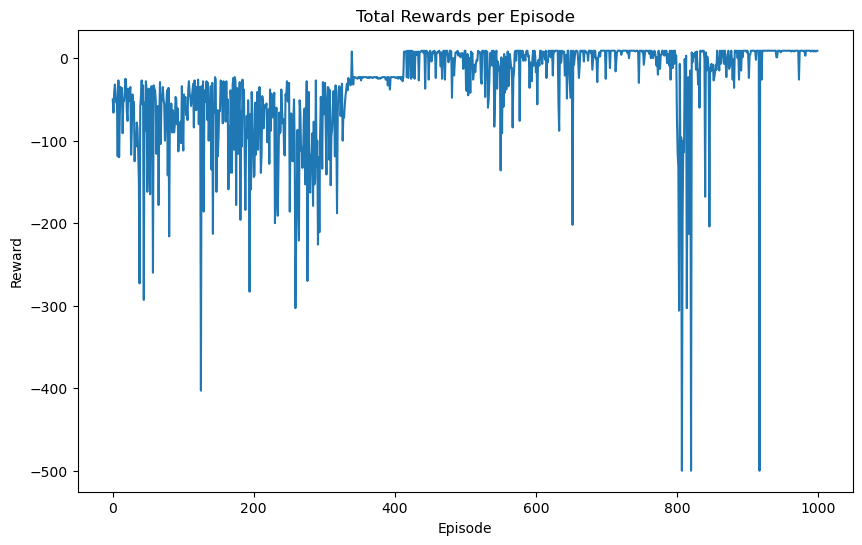

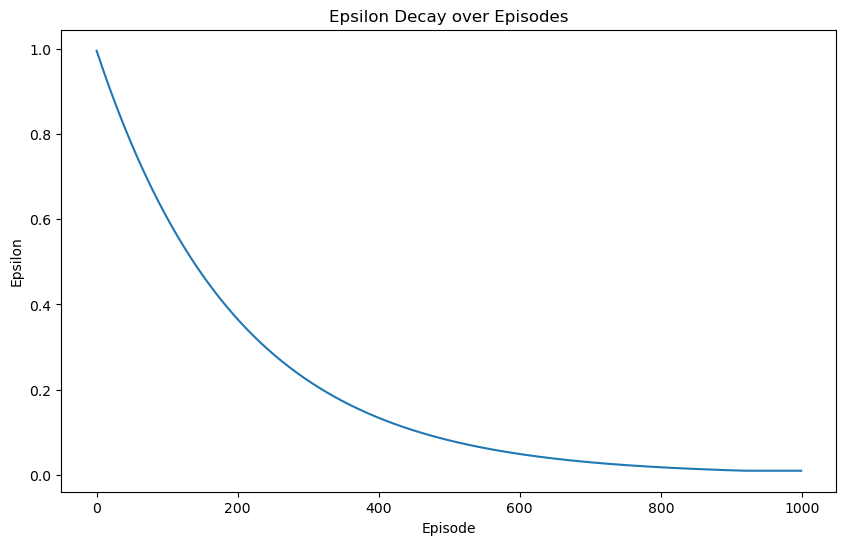

In [83]:
#reward per episode plot
def plot_metrics(episode_total_rewards, epsilon_decay_history):
    plt.figure(figsize=(10, 6))
    plt.plot(episode_total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Total Rewards per Episode')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_decay_history)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay over Episodes')
    plt.show()

if __name__ == "__main__":
    #initialize the environment
    env = daenv_deter()  
    online_q_network = DQNetwork(STATE_DIM, ACTION_DIM)
    target_q_network = DQNetwork(STATE_DIM, ACTION_DIM)
    #initialize the target Q-network
    target_q_network.load_state_dict(online_q_network.state_dict())
    #initialize experience replay
    replay_buffer = ExperienceReplay(BUFFER_SIZE)
    optimizer = optim.Adam(online_q_network.parameters(), lr=LEARNING_RATE)
    #train the Double DQN agent
    episode_total_rewards, epsilon_decay_history = train_double_dqn(env,online_q_network,target_q_network,replay_buffer,optimizer,TOTAL_EPISODES,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,EPSILON_DECAY,EPSILON_MIN,TARGET_UPDATE_FREQUENCY,MAX_STEPS)
    double_dqn_rewards = episode_total_rewards 
    plot_metrics(episode_total_rewards, epsilon_decay_history)
    with open('smedurik_usannapu_assignment2_part3_double_dqn.pkl', 'wb') as f:
        pickle.dump(online_q_network.state_dict(), f)


Episode: 1, Total Reward: 9
Episode: 2, Total Reward: 9
Episode: 3, Total Reward: 9
Episode: 4, Total Reward: 9
Episode: 5, Total Reward: 9


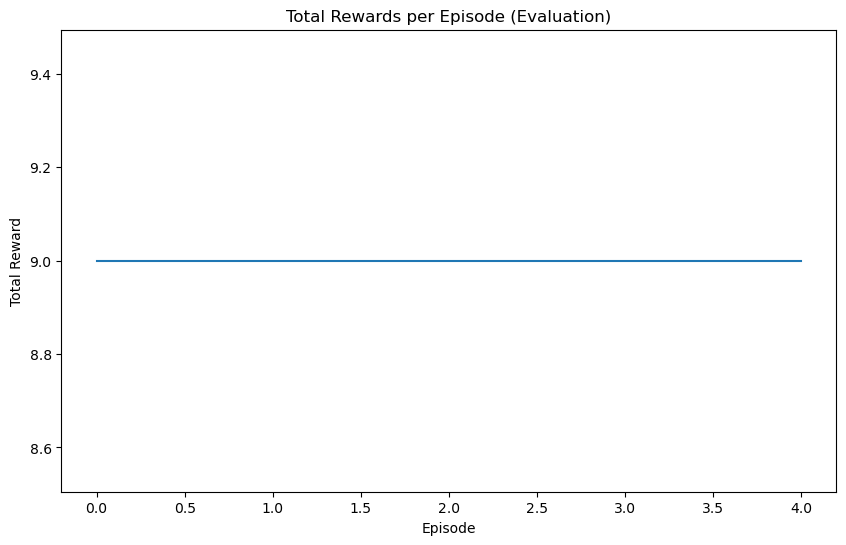

In [89]:
def evaluate_agent(env, q_network, num_episodes):
    total_rewards = []  
    for episode in range(num_episodes):
        state, carry_item = env.reset()  #reset the environment 
        state = flatten_state(state, carry_item)  #flatten the initial state
        episode_reward = 0  
        for step in range(MAX_STEPS):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)  #convert state to tensor
            with torch.no_grad():
                q_values = q_network(state_tensor)  #get Q-values 
                action = torch.argmax(q_values).item()  #choose the greedy action
            #take action and observe the next state and reward
            next_state, reward, done, info = env.step(env.action_full[action])
            next_state = flatten_state(next_state, env.carry_item)  
            episode_reward += reward  
            state = next_state  
            if done:
                break 
        total_rewards.append(episode_reward)  
        print(f"Episode: {episode + 1}, Total Reward: {episode_reward}") 
    return total_rewards  

if __name__ == "__main__":
    env = daenv_deter()  
    online_q_network = DQNetwork(STATE_DIM, ACTION_DIM)
    with open('smedurik_usannapu_assignment2_part3_double_dqn.pkl', 'rb') as f:
        online_q_network.load_state_dict(pickle.load(f))
    num_evaluation_episodes = 5
    evaluation_rewards = evaluate_agent(env, online_q_network, num_evaluation_episodes)
    #plot the total reward per episode 
    plt.figure(figsize=(10, 6))
    plt.plot(evaluation_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards per Episode (Evaluation)')
    plt.show()


## part 3.2

In [99]:
class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),  #layer 1
            nn.ReLU(),                  #activation
            nn.Linear(128, 256),        #layer 2
            nn.ReLU(),                  #activation
            nn.Linear(256, output_dim)  #output Layer
        )

    def forward(self, state):
        #performing forward pass 
        return self.fc(state)

#define Experience Replay
class ExperienceReplay:
    def __init__(self, buffer_capacity):
        #initialize deque
        self.buffer = deque(maxlen=buffer_capacity)

    def store(self, state, action, reward, next_state, done):
        #store an experience in replay buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        #randomly sampling 
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        #return the number of experiences in the buffer
        return len(self.buffer)
        
#hyperparameters
STATE_DIM = 4  
ACTION_DIM = 2  
BUFFER_SIZE = 10000
BATCH_SIZE = 32
DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.001
TARGET_UPDATE_FREQUENCY = 10
TOTAL_EPISODES = 1000
EPSILON_START = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MAX_STEPS = 500
#function to train the double dqn agent 
def train_double_dqn(env, online_q_network, target_q_network, replay_buffer, optimizer, total_episodes, batch_size, gamma, epsilon_start, epsilon_decay, epsilon_min, target_update_freq, max_steps, early_stopping_threshold=470, early_stopping_window=10):
    epsilon = epsilon_start #initialize epsilon 
    cartpole_reward = []  #to store rewards 
    epsilon_history = [] #to store epsilon values 
    for episode in range(total_episodes):
        state, info = env.reset() #reset the environment 
        episode_reward = 0 #initialize the total rewards for current episode 
        for step in range(max_steps):
            #epsilon-greedy action 
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  #choose a random action 
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0) #convert state to tensor 
                with torch.no_grad():
                    q_values = online_q_network(state_tensor) #get Q-values 
                    action = torch.argmax(q_values).item() #choose greedy action 
             #take the chosen action and the next state and reward
            next_state, reward, done, info, e_info = env.step(action)
            episode_reward += reward
             #store the experience in replay buffer
            replay_buffer.store(state, action, reward, next_state, done)
            state = next_state #update current state 
             #train the network if there are enough experiences
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states_tensor = torch.FloatTensor(states)  #convert states to tensor
                actions_tensor = torch.LongTensor(actions).unsqueeze(1) #convert actions to tensor
                rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1) #convert rewards to tensor
                next_states_tensor = torch.FloatTensor(next_states) #convert next states to tensor
                dones_tensor = torch.FloatTensor(dones).unsqueeze(1)
                #cal current q values
                current_q_values = online_q_network(states_tensor).gather(1, actions_tensor)
                 #cal target q values
                with torch.no_grad():
                    next_actions = online_q_network(next_states_tensor).argmax(1).unsqueeze(1)
                    target_q_values = target_q_network(next_states_tensor).gather(1, next_actions)
                target_q_values = rewards_tensor + gamma * target_q_values * (1 - dones_tensor)
                loss = nn.MSELoss()(current_q_values, target_q_values)
                 #optimization step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if done:
                break
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        cartpole_reward.append(episode_reward)  
        epsilon_history.append(epsilon)
        if episode % target_update_freq == 0:
            target_q_network.load_state_dict(online_q_network.state_dict())

        #check for early stopping if avg reward is above 470 
        if len(cartpole_reward) >= early_stopping_window:  
            avg_reward = np.mean(cartpole_reward[-early_stopping_window:])  
            if avg_reward >= early_stopping_threshold:
                print(f"Early stopping at episode {episode + 1}, average reward: {avg_reward}")
                break
        print(f"Episode: {episode + 1}, Reward: {episode_reward}, Epsilon: {epsilon}")
    return cartpole_reward, epsilon_history  


Episode: 1, Reward: 14.0, Epsilon: 0.995
Episode: 2, Reward: 73.0, Epsilon: 0.990025
Episode: 3, Reward: 22.0, Epsilon: 0.985074875
Episode: 4, Reward: 11.0, Epsilon: 0.9801495006250001
Episode: 5, Reward: 14.0, Epsilon: 0.9752487531218751
Episode: 6, Reward: 23.0, Epsilon: 0.9703725093562657
Episode: 7, Reward: 25.0, Epsilon: 0.9655206468094844
Episode: 8, Reward: 14.0, Epsilon: 0.960693043575437
Episode: 9, Reward: 15.0, Epsilon: 0.9558895783575597
Episode: 10, Reward: 17.0, Epsilon: 0.9511101304657719
Episode: 11, Reward: 10.0, Epsilon: 0.946354579813443
Episode: 12, Reward: 13.0, Epsilon: 0.9416228069143757
Episode: 13, Reward: 35.0, Epsilon: 0.9369146928798039
Episode: 14, Reward: 12.0, Epsilon: 0.9322301194154049
Episode: 15, Reward: 16.0, Epsilon: 0.9275689688183278
Episode: 16, Reward: 13.0, Epsilon: 0.9229311239742362
Episode: 17, Reward: 12.0, Epsilon: 0.918316468354365
Episode: 18, Reward: 32.0, Epsilon: 0.9137248860125932
Episode: 19, Reward: 29.0, Epsilon: 0.90915626158253

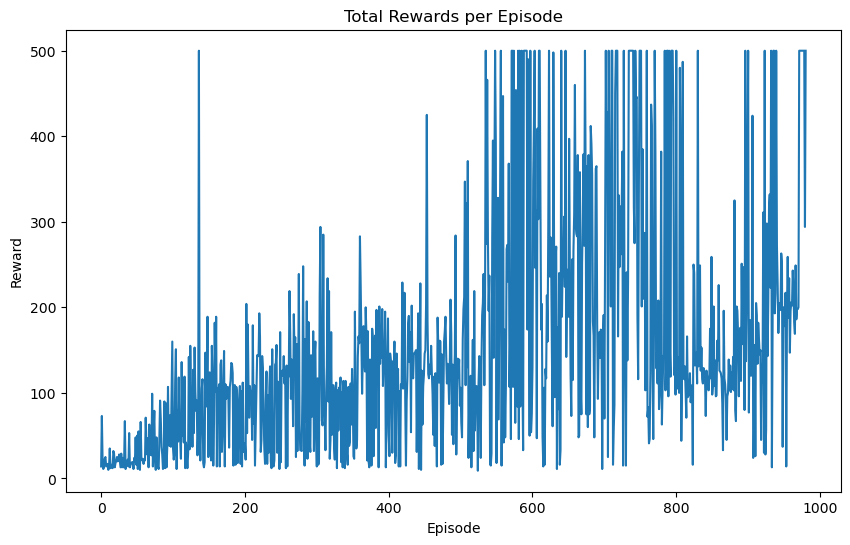

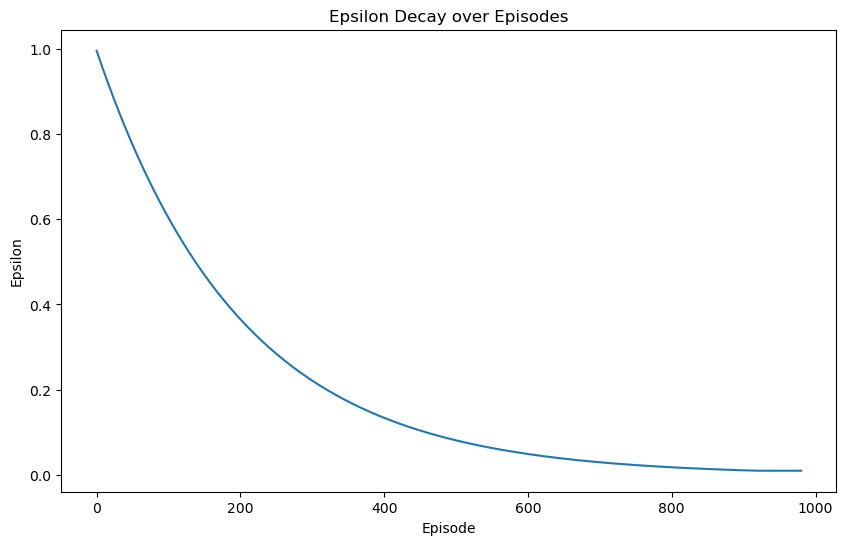

In [101]:
#to plot total reward per episode 
def plot_metrics(rewards, epsilon_values):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Total Rewards per Episode')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_values)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay over Episodes')
    plt.show()

if __name__ == "__main__":
    env = gym.make('CartPole-v1')  
    online_q_network = DQNetwork(STATE_DIM, ACTION_DIM)  
    target_q_network = DQNetwork(STATE_DIM, ACTION_DIM)
    target_q_network.load_state_dict(online_q_network.state_dict())
    replay_buffer = ExperienceReplay(BUFFER_SIZE)
    optimizer = optim.Adam(online_q_network.parameters(), lr=LEARNING_RATE)
    cartpole_reward, epsilon_values = train_double_dqn(env,online_q_network,target_q_network,replay_buffer,optimizer,TOTAL_EPISODES,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,EPSILON_DECAY,EPSILON_MIN,TARGET_UPDATE_FREQUENCY,MAX_STEPS)
    double_dqn_rewards_cartpole = cartpole_reward  
    plot_metrics(cartpole_reward, epsilon_values) 
    with open('cartpole_double_dqn.pkl', 'wb') as f:
        pickle.dump(online_q_network.state_dict(), f)


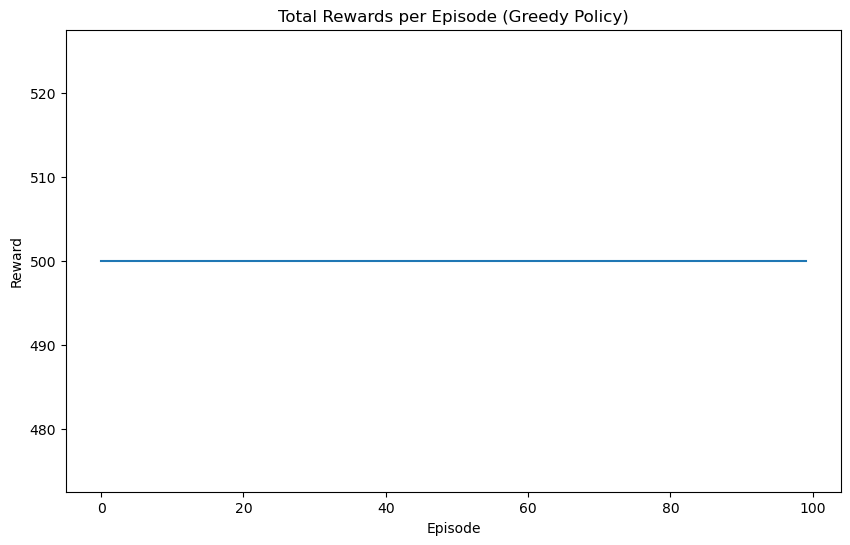

In [103]:
def evaluate_greedy_policy(env, q_network, episodes=100, max_steps=500):
    total_rewards = []
    for episode in range(episodes):
        state, info = env.reset()
        episode_reward = 0
        for step in range(max_steps):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = q_network(state_tensor)
                action = torch.argmax(q_values).item()
            next_state, reward, done, info, e_info = env.step(action)
            episode_reward += reward
            state = next_state
            if done:
                break
        total_rewards.append(episode_reward)
    return total_rewards

def plot_greedy_metrics(total_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Total Rewards per Episode (Greedy Policy)')
    plt.show()

if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    online_q_network = DQNetwork(STATE_DIM, ACTION_DIM)  
    with open('cartpole_double_dqn.pkl', 'rb') as f:
        online_q_network.load_state_dict(pickle.load(f))
    total_rewards_greedy = evaluate_greedy_policy(env, online_q_network, episodes=100)
    plot_greedy_metrics(total_rewards_greedy)


In [105]:
#define the DQNetwork class
class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),  #layer 1
            nn.ReLU(),                  #activation
            nn.Linear(128, 256),        #layer 2
            nn.ReLU(),                  #activation
            nn.Linear(256, output_dim)  #output Layer
        )

    def forward(self, state):
        return self.fc(state)

#define Experience Replay
class ExperienceReplay:
    def __init__(self, buffer_capacity):
         #initialize deque
        self.buffer = deque(maxlen=buffer_capacity)

    def store(self, state, action, reward, next_state, done):
        #store an experience in replay buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
         #randomly sampling 
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
         #return the number of experiences in the buffer
        return len(self.buffer)

#hyperparameters
STATE_DIM = 1  
ACTION_DIM = 4  
BUFFER_SIZE = 10000
BATCH_SIZE = 32
DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.001
TARGET_UPDATE_FREQUENCY = 10
TOTAL_EPISODES = 1000
EPSILON_START = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MAX_STEPS = 500

def get_state(env, state):
    #create a one-hot encoded vector for the given state
    state_vector = np.zeros(env.observation_space.n)  
    state_vector[state] = 1
    return state_vector
    
#function to train the double dqn agent 
def train_double_dqn(env, online_q_network, target_q_network, replay_buffer, optimizer, total_episodes, batch_size, gamma, epsilon_start, epsilon_decay, epsilon_min, target_update_freq, max_steps):
    epsilon = epsilon_start  #initialize epsilon 
    cliffwalking_reward = []  #to store rewards 
    epsilon_history = [] #to store epsilon values 
    for episode in range(total_episodes):
        state = env.reset()    #reset the environment
        if isinstance(state, tuple):
            state = state[0]  
        state = get_state(env, state)  
        episode_reward = 0 #initialize the total rewards for current episode 
        for step in range(max_steps):
            #epsilon-greedy action 
            if np.random.rand() < epsilon:
                action = env.action_space.sample()   #choose a random action 
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0) #convert state to tensor 
                with torch.no_grad():
                    q_values = online_q_network(state_tensor) #get Q-values 
                    action = torch.argmax(q_values).item() #choose greedy action 
            #take the chosen action and the next state and reward
            next_state, reward, done, info,e_info = env.step(action)
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            next_state = get_state(env, next_state) 
            episode_reward += reward
            #store the experience in replay buffer
            replay_buffer.store(state, action, reward, next_state, done)
            state = next_state
             #train the network if there are enough experiences
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states_tensor = torch.FloatTensor(states)
                actions_tensor = torch.LongTensor(actions).unsqueeze(1)
                rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1)
                next_states_tensor = torch.FloatTensor(next_states)
                dones_tensor = torch.FloatTensor(dones).unsqueeze(1)
                current_q_values = online_q_network(states_tensor).gather(1, actions_tensor)
                with torch.no_grad():
                    next_actions = online_q_network(next_states_tensor).argmax(1).unsqueeze(1)
                    target_q_values = target_q_network(next_states_tensor).gather(1, next_actions)
                target_q_values = rewards_tensor + gamma * target_q_values * (1 - dones_tensor)
                loss = nn.MSELoss()(current_q_values, target_q_values)
                #optimization step 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if done:
                break
        
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        cliffwalking_reward.append(episode_reward)  
        epsilon_history.append(epsilon)
        if episode % target_update_freq == 0:
            target_q_network.load_state_dict(online_q_network.state_dict())
        print(f"Episode: {episode + 1}, Reward: {episode_reward}, Epsilon: {epsilon}")
    return cliffwalking_reward, epsilon_history  

Episode: 1, Reward: -6539, Epsilon: 0.995
Episode: 2, Reward: -4361, Epsilon: 0.990025
Episode: 3, Reward: -5747, Epsilon: 0.985074875
Episode: 4, Reward: -5648, Epsilon: 0.9801495006250001
Episode: 5, Reward: -4856, Epsilon: 0.9752487531218751
Episode: 6, Reward: -4757, Epsilon: 0.9703725093562657
Episode: 7, Reward: -5846, Epsilon: 0.9655206468094844
Episode: 8, Reward: -5252, Epsilon: 0.960693043575437
Episode: 9, Reward: -2678, Epsilon: 0.9558895783575597
Episode: 10, Reward: -3866, Epsilon: 0.9511101304657719
Episode: 11, Reward: -5054, Epsilon: 0.946354579813443
Episode: 12, Reward: -4757, Epsilon: 0.9416228069143757
Episode: 13, Reward: -6539, Epsilon: 0.9369146928798039
Episode: 14, Reward: -5054, Epsilon: 0.9322301194154049
Episode: 15, Reward: -2424, Epsilon: 0.9275689688183278
Episode: 16, Reward: -5252, Epsilon: 0.9229311239742362
Episode: 17, Reward: -5450, Epsilon: 0.918316468354365
Episode: 18, Reward: -5648, Epsilon: 0.9137248860125932
Episode: 19, Reward: -5252, Epsilo

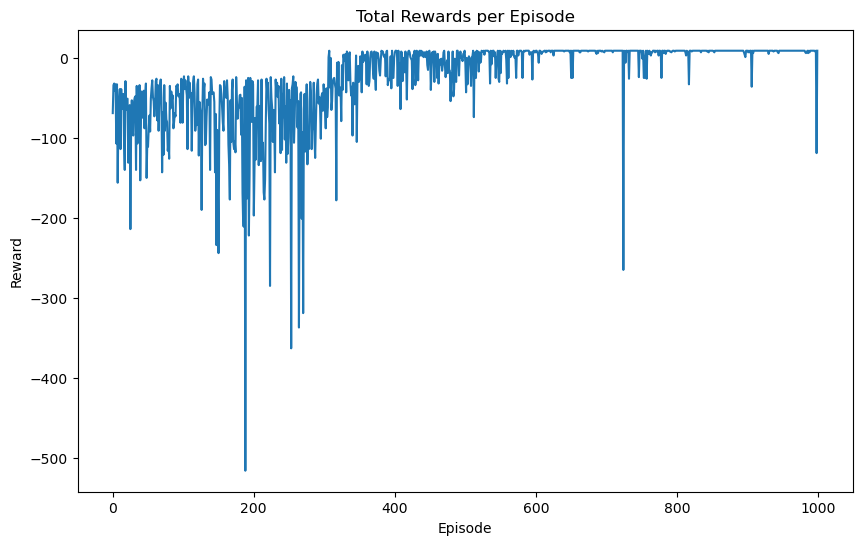

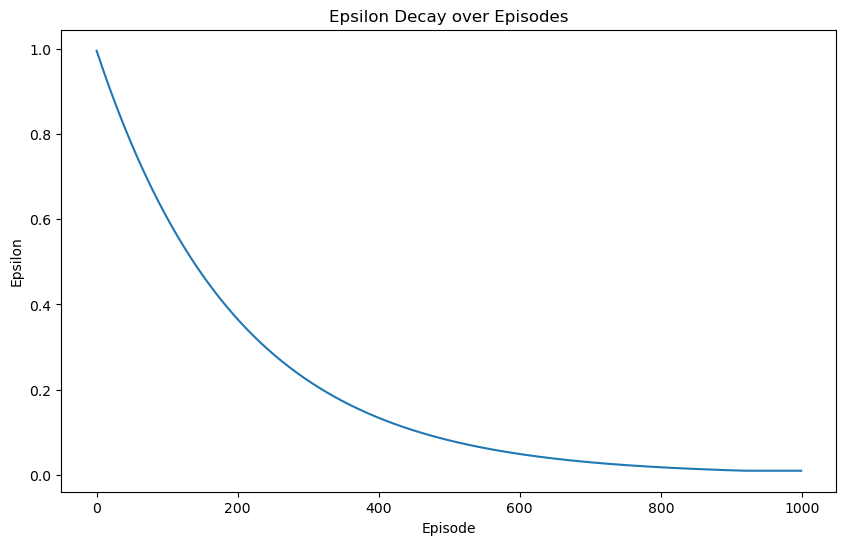

In [107]:
#plot total reward per episode 
def plot_metrics(cliffwalking_reward, epsilon_values):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Total Rewards per Episode')
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_values)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay over Episodes')
    plt.show()
    
if __name__ == "__main__":
    env = gym.make('CliffWalking-v0')  
    online_q_network = DQNetwork(env.observation_space.n, ACTION_DIM)
    target_q_network = DQNetwork(env.observation_space.n, ACTION_DIM)
    target_q_network.load_state_dict(online_q_network.state_dict())
    replay_buffer = ExperienceReplay(BUFFER_SIZE)
    optimizer = optim.Adam(online_q_network.parameters(), lr=LEARNING_RATE)
    cliffwalking_reward, epsilon_values = train_double_dqn(env,online_q_network,target_q_network,replay_buffer,optimizer,TOTAL_EPISODES,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,EPSILON_DECAY,EPSILON_MIN,TARGET_UPDATE_FREQUENCY,MAX_STEPS)
    plot_metrics(cliffwalking_reward, epsilon_values)  
    double_dqn_rewards_cliffwalking = cliffwalking_reward
    with open('cliffwalking_double_dqn.pkl', 'wb') as f:
        pickle.dump(online_q_network.state_dict(), f)


Evaluation Episode: 1, Reward: -13
Evaluation Episode: 2, Reward: -13
Evaluation Episode: 3, Reward: -13
Evaluation Episode: 4, Reward: -13
Evaluation Episode: 5, Reward: -13


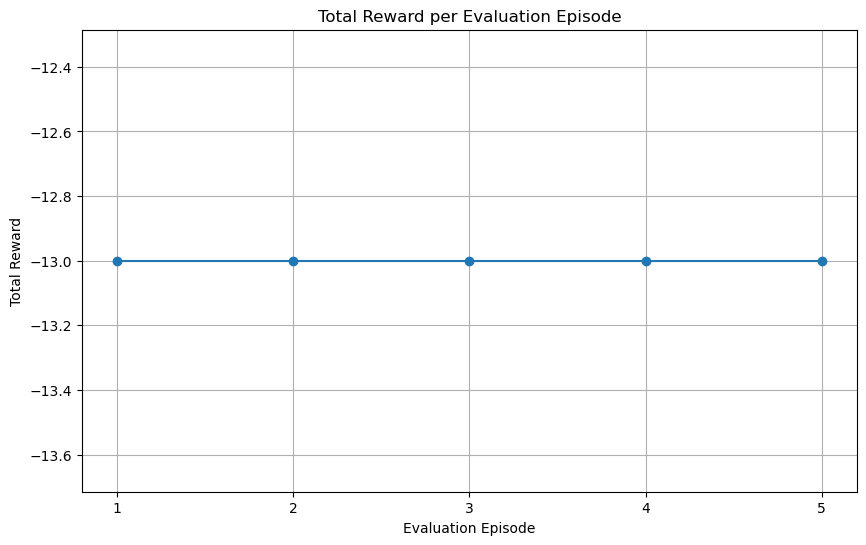

In [112]:
# Evaluation function
def evaluate_agent(env, q_network, total_episodes, max_steps):
    total_rewards = []
    for episode in range(total_episodes):
        state = env.reset()  
        if isinstance(state, tuple):
            state = state[0] 
        state = get_state(env, state)  
        episode_reward = 0
        for step in range(max_steps):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = q_network(state_tensor)
                action = torch.argmax(q_values).item()  
            next_state, reward, done, info,e_info = env.step(action)
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            next_state = get_state(env, next_state)  
            episode_reward += reward
            state = next_state
            if done:
                break
        total_rewards.append(episode_reward)
        print(f"Evaluation Episode: {episode + 1}, Reward: {episode_reward}")
    return total_rewards

#plot greedy graph 
if __name__ == "__main__":
    evaluation_episodes = 5
    total_rewards = evaluate_agent(env, online_q_network, evaluation_episodes, MAX_STEPS)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, evaluation_episodes + 1), total_rewards, marker='o')
    plt.xlabel('Evaluation Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Evaluation Episode')
    plt.xticks(range(1, evaluation_episodes + 1))
    plt.grid()
    plt.show()


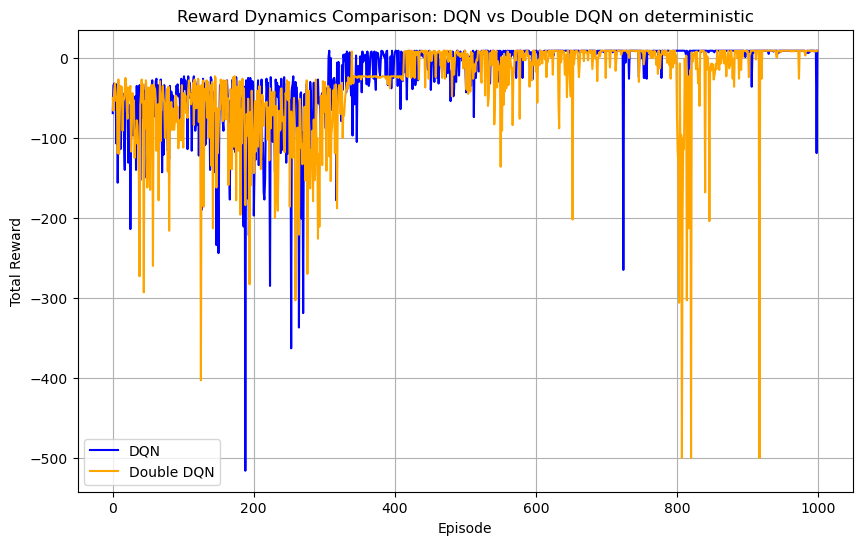

In [120]:
#comparing dqn and double dqn on deterministic env
dqn_rewards = rewards 
double_dqn_rewards = episode_total_rewards 
def plot_comparison(dqn_rewards, double_dqn_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(dqn_rewards, label='DQN', color='blue')
    plt.plot(double_dqn_rewards, label='Double DQN', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Reward Dynamics Comparison: DQN vs Double DQN on deterministic')
    plt.legend()
    plt.grid()
    plt.show()

plot_comparison(dqn_rewards, double_dqn_rewards)


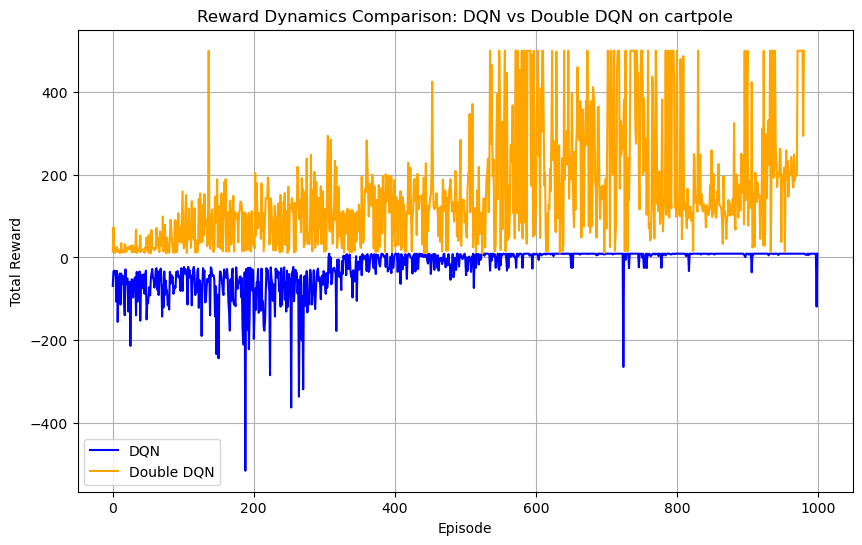

In [122]:
##comparing dqn and double dqn on cartpole
dqn_rewards_cartpole = rewards 
double_dqn_rewards_cartpole = cartpole_reward
def plot_comparison(dqn_rewards, double_dqn_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(dqn_rewards, label='DQN', color='blue')
    plt.plot(double_dqn_rewards, label='Double DQN', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Reward Dynamics Comparison: DQN vs Double DQN on cartpole')
    plt.legend()
    plt.grid()
    plt.show()

plot_comparison(dqn_rewards_cartpole,double_dqn_rewards_cartpole)

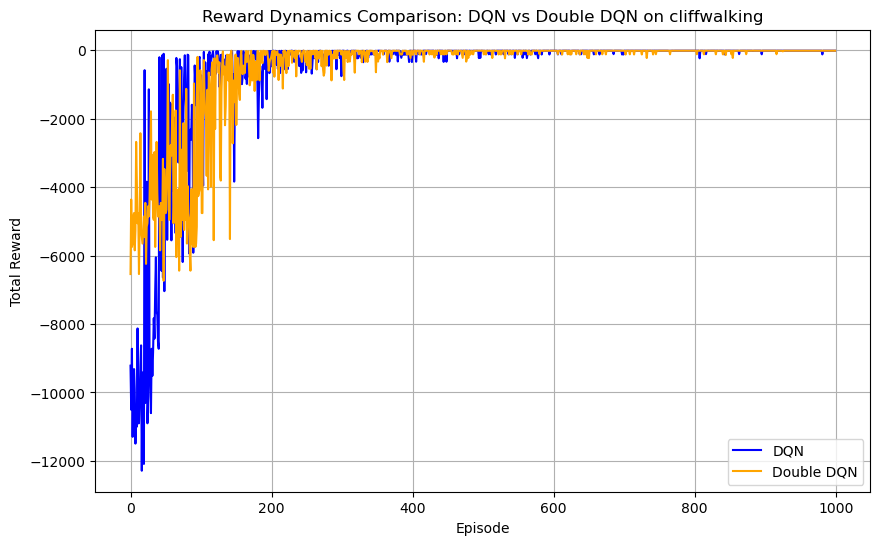

In [124]:
#comparing dqn and double dqn on cliffwalking
dqn_rewards_cliffwalking = rewards_list
double_dqn_rewards_cliffwalking = cliffwalking_reward
def plot_comparison(dqn_rewards, double_dqn_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(dqn_rewards, label='DQN', color='blue')
    plt.plot(double_dqn_rewards, label='Double DQN', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Reward Dynamics Comparison: DQN vs Double DQN on cliffwalking')
    plt.legend()
    plt.grid()
    plt.show()

plot_comparison(dqn_rewards_cliffwalking,double_dqn_rewards_cliffwalking )

## References 

1)https://medium.com/@ameetsd97/deep-double-q-learning-why-you-should-use-it-bedf660d5295

2)https://pylessons.com/CartPole-DDQN

3)https://medium.com/@leosimmons/double-dqn-implementation-to-solve-openai-gyms-cartpole-v-0-df554cd0614d

4)https://medium.com/@lgvaz/understanding-q-learning-the-cliff-walking-problem-80198921abbc

5)https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html